## 

In [4]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import torch
from time import time
from MomentLearn import utils
from MomentLearn import model as model_utils
from MomentLearn.model import ContrastiveLearn as Net
import prody as pd
import matplotlib.pyplot as plt
from caretta.score_functions import get_caretta_score
from caretta.multiple_alignment import tm_score
from caretta import superposition_functions, helper, multiple_alignment

In [5]:
X_names, mapk_pdb_id_to_class = utils.get_example_metadata()
class_mapping = {"JNK": 0, "Erk": 1, "p38": 2}
mapping = [class_mapping[mapk_pdb_id_to_class[k]] for k in X_names]

In [7]:
start_time = time()
pdbs = []
for i, (pdb_id, chain) in enumerate(X_names):
    if i > 0 and i % 50 == 0:
        print(f"{i} proteins fetched in {(time() - start_time):.2f} seconds")
    pdbs.append(pd.parsePDB(pdb_id, chain=chain))

In [4]:
from geometricus import MomentInvariants, SplitType, MomentType

invariants_kmer = []
invariants_radius = []

start_time = time()
for i, key in enumerate(X_names):
    if i > 0 and i % 50 == 0:
        print(f"{i} proteins in {(time() - start_time):.2f} seconds")
    invariants_kmer.append(MomentInvariants.from_prody_atomgroup(key, pdbs[i], split_type=SplitType.KMER, split_size=27, moment_types=list(MomentType)))
    invariants_radius.append(MomentInvariants.from_prody_atomgroup(key, pdbs[i], split_type=SplitType.RADIUS, split_size=10, moment_types=list(MomentType)))

50 proteins in 8.20 seconds
100 proteins in 10.63 seconds
150 proteins in 12.85 seconds
200 proteins in 15.32 seconds
250 proteins in 17.71 seconds
300 proteins in 20.35 seconds
350 proteins in 23.21 seconds
400 proteins in 25.80 seconds
450 proteins in 28.11 seconds
500 proteins in 31.39 seconds


In [61]:
ind_moments_kmer = [((np.sign(x.moments) * np.log1p(np.abs(x.moments))) / 27).astype("float32") for x in invariants_kmer]
ind_moments_radius = [((np.sign(x.moments) * np.log1p(np.abs(x.moments))) / 10).astype("float32") for x in invariants_radius]
ind_moments = [np.hstack((ind_moments_kmer[i], ind_moments_radius[i])) for i in range(len(ind_moments_radius))]

In [62]:
no_out_channels = 1
epoch = 20_000
model = Net(ind_moments[0].shape[1], no_out_channels)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

No handles with labels found to put in legend.


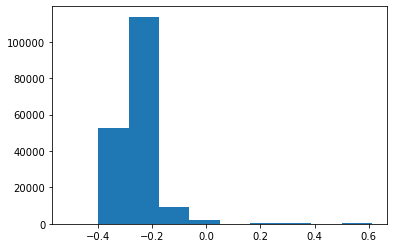

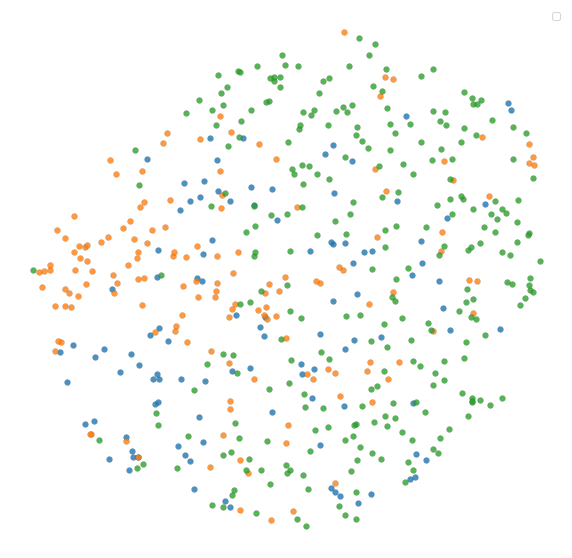

In [63]:
utils.plot_umap(ind_moments, model, mapping)

In [64]:
current_losses = []
for e in range(epoch):
    x, dist, y = model_utils.sample_random_moment_with_close_distant(ind_moments,
                                                                     batch=300,
                                                                     number_of_moments=ind_moments[0].shape[1])

    x, dist, y = model(x, dist, y)
    loss = model_utils.loss_func(x, dist, y)
    optimizer.zero_grad()
    loss.backward()
    current_losses.append(loss.item())
    optimizer.step()
    if e % 1000 == 0:
        print(np.mean(current_losses))
        current_losses = []

0.2050914317369461
0.10783439790084957
0.069436506845057
0.06764444536715745
0.06579561894387007
0.06412909107282758
0.06227045902982354
0.060820606749504805
0.05892791274189949
0.058004048351198434
0.05711603213101626
0.05595135805010796
0.05601938119530678
0.05542244171723723
0.05485660440847278
0.054497863233089444
0.05461293786019087
0.05442902206256986
0.05435436270385981
0.05407575786113739


No handles with labels found to put in legend.


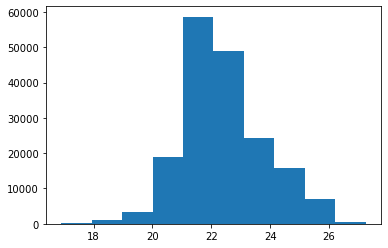

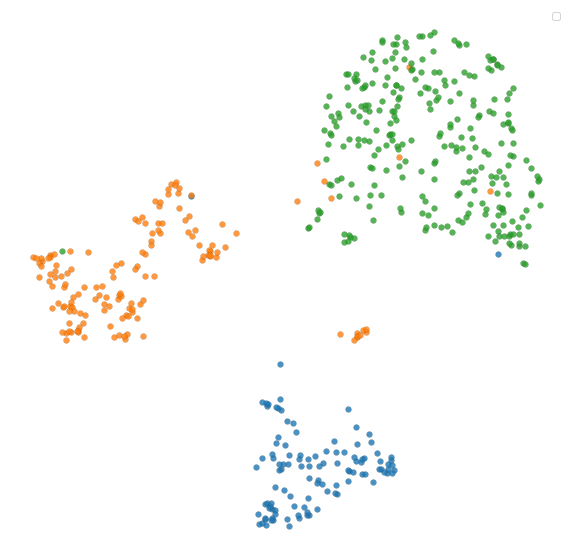

In [65]:
utils.plot_umap(ind_moments, model, mapping)

In [19]:
from caretta import dynamic_time_warping as dtw

In [20]:
def fill_template_kmer_coords(coords, shape=(27, 3)):
    padded_coords = np.zeros(shape)
    padded_coords[:coords.shape[0]] = coords
    return padded_coords

In [21]:
proteins = [model.forward_single(torch.tensor(x.astype("float32"))).cpu().detach().numpy() for x in ind_moments]
residue_coords = [x.coordinates for x in invariants_kmer]

In [22]:
i1 = 3
i2 = -1
protein_a = proteins[i1]
protein_b = proteins[i2]
coords_a = residue_coords[i1]
coords_b = residue_coords[i2]

In [23]:
def svd_superimpose(coords_1, coords_2):
    centroid_1, centroid_2 = (
        helper.nb_mean_axis_0(coords_1),
        helper.nb_mean_axis_0(coords_2),
    )
    coords_1_c, coords_2_c = coords_1 - centroid_1, coords_2 - centroid_2
    correlation_matrix = np.dot(coords_2_c.T, coords_1_c)
    u, s, v = np.linalg.svd(correlation_matrix)
    reflect = np.linalg.det(u) * np.linalg.det(v) < 0
    if reflect:
        s[-1] = -s[-1]
        u[:, -1] = -u[:, -1]
    rotation_matrix = np.dot(u, v)
    translation_matrix = centroid_1 - np.dot(centroid_2, rotation_matrix)
    return rotation_matrix.astype(np.float64), translation_matrix.astype(np.float64)

In [51]:
score_matrix = np.array([[np.abs(x - y).sum() for y in protein_b] for x in protein_a])
score_matrix = score_matrix.max() - score_matrix
p1_idx, p2_idx, _ = dtw.dtw_align(score_matrix, gap_open_penalty=1, gap_extend_penalty=0.5)

In [52]:
def score(coords1, coords2, gamma=2):
    rot, trans = svd_superimpose(np.array(coords1).astype(float), np.array(coords2).astype(float))
    coords2_rotated = np.dot(coords2 - np.mean(coords2, axis=0), rot)
    coords1_translated = coords1 - np.mean(coords1, axis=0)
    return get_caretta_score(coords1_translated, coords2_rotated).mean(), (coords1_translated, coords2_rotated)

core_p1_idx, core_p2_idx = helper.get_common_positions(p1_idx, p2_idx)
aligned_score, (p1_rotated_common, p2_rotated_common) = score(coords_a[core_p1_idx], coords_b[core_p2_idx])
unaligned_score, _ = score(coords_a[:min(coords_a.shape[0], coords_b.shape[0])], coords_b[:min(coords_a.shape[0], coords_b.shape[0])])
aligned_score, unaligned_score

(0.7425747560967513, 0.036702942631759244)

In [53]:
def fill_gaps_for_plotting(alignment_idx):
    while np.where(alignment_idx == -1)[0].shape[0] != 0:
        current = np.where(alignment_idx == -1)[0][0]
        if current == 0:
            alignment_idx[current] = alignment_idx[np.where(alignment_idx != -1)[0][0]]
        else:
            alignment_idx[current] = alignment_idx[current - 1]
    return alignment_idx

In [54]:
p1_idx_filled, p2_idx_filled = fill_gaps_for_plotting(p1_idx), fill_gaps_for_plotting(p2_idx)

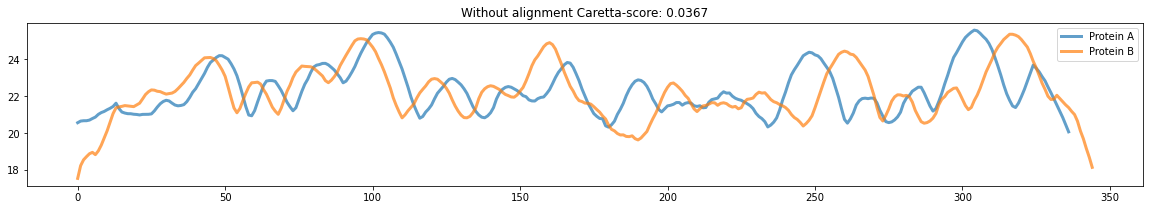

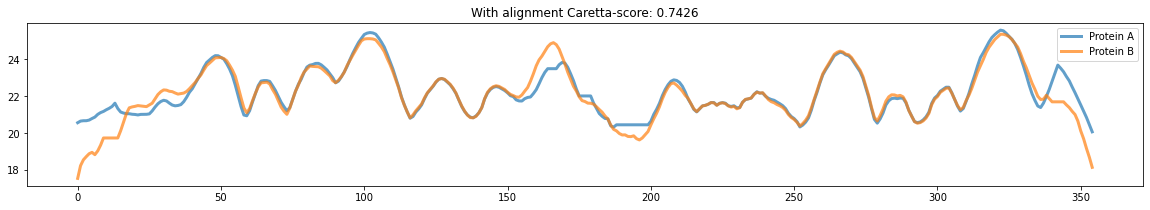

In [56]:
plt.figure(figsize=(20,3))
plt.plot(protein_a, lw=3, alpha=.7)
plt.plot(protein_b, lw=3, alpha=.7)
plt.title(f"Without alignment Caretta-score: {unaligned_score:.4f}")
plt.legend(["Protein A", "Protein B"])
plt.show()
plt.figure(figsize=(20,3))
plt.plot(protein_a[p1_idx_filled], lw=3, alpha=.7)
plt.plot(protein_b[p2_idx_filled], lw=3, alpha=.7)
plt.title(f"With alignment Caretta-score: {aligned_score:.4f}")
plt.legend(["Protein A", "Protein B"])
plt.show()